# Joint analysis of paired and unpaired multiomic data with MultiVI

MultiVI is used for the joint analysis of scRNA and scATAC-seq datasets that were jointly profiled (multiomic / paired) and single-modality datasets (only scRNA or only scATAC). MultiVI uses the paired data as an anchor to align and merge the latent spaces learned from each individual modality.

This tutorial walks through how to read multiomic data, create a joint object with paired and unpaired data, set-up and train a MultiVI model, visualize the resulting latent space, and run differential analyses.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
import os
import tempfile

import muon
import numpy as np
import requests
import scanpy as sc
import scvi
import seaborn as sns
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.3.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Data acquisition

First we download a sample multiome dataset from 10X, which we have preprocessed in the scvi-tools [preprocessing tutorial](../notebooks/processing/preprocessing). We'll use this throughout this tutorial.
Importantly, MultiVI assumes that there are shared features between the datasets. This is trivial for gene expression datasets, which generally use the same set of genes as features. For ATAC-seq peaks, this is less trivial, and often requires preprocessing steps with other tools to get all datasets to use a shared set of peaks. That can be achieved with tools like SnapATAC, ArchR, and CellRanger in the case of 10X data.

```{important}
MultiVI requires the datasets to use shared features. scATAC-seq datasets need to be processed to use a shared set of peaks.
```

```{note}
This dataset has been altered such that it contains both multimodal and single-modal data. There are 12012 cells total, and we've corrupted some data such that there are 4004 multimodal cells, 4004 cells with only gene expression, and 4004 cells with only peaks. This process can be seen in the relevant section of the preprocessing tutorial. We do this in order to demonstrate MultiVI's ability to mix multimodal and unimodal data.
```

Below we download the already preprocessed dataset.

In [5]:
# download preprocessed dataset
mdata_path = os.path.join(save_dir.name, "pbmc_10k_preprocessed.h5mu")

# Figshare direct download URL
url = "https://figshare.com/ndownloader/files/52859300"

# Download only if file doesn't already exist
if not os.path.exists(mdata_path):
    print(f"Downloading MuData file to {mdata_path}...")
    r = requests.get(url)
    with open(mdata_path, "wb") as f:
        f.write(r.content)

# Load the MuData object
mdata = muon.read_h5mu(mdata_path)

/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


```{important}
MultiVI requires the features to be ordered so that genes appear before genomic regions. This must be enforced by the user.
```

## Setup and Training MultiVI

We can now set up and train the MultiVI model!

First, we need to setup the Anndata object using the `setup_anndata` function. At this point we specify any batch annotation that the model would account for.
**Importantly**, the main batch annotation, specific by `batch_key`, should correspond to the modality of the cells.

Other batch annotations (e.g if there are multiple ATAC batches) should be provided using the `categorical_covariate_keys`.

The actual values of categorical covariates (include `batch_key`) are not important, as long as they are different for different samples.
I.e it is not important to call the expression-only samples "expression", as long as they are called something different than the multi-modal and accessibility-only samples.

```{important}
MultiVI requires the main batch annotation to correspond to the modality of the samples. Other batch annotation, such as in the case of multiple RNA-only batches, can be specified using `categorical_covariate_keys`.
```

In [6]:
mdata

MuData object with n_obs × n_vars = 12012 × 83785
  var:	'gene_ids', 'feature_types', 'n_cells'
  2 modalities
    rna:	12012 x 3164
      var:	'gene_ids', 'feature_types', 'n_cells'
    atac:	12012 x 80621
      var:	'gene_ids', 'feature_types', 'n_cells'

In [10]:
# For our sparse matrices, we want CSR rather than CSC as training will be faster
# We convert here since our downloaded dataset uses CSC
mdata.mod["rna"].X = mdata.mod["rna"].X.tocsr()
mdata.mod["atac"].X = mdata.mod["atac"].X.tocsr()

In [11]:
mdata.mod["rna"]

AnnData object with n_obs × n_vars = 12012 × 3164
    var: 'gene_ids', 'feature_types', 'n_cells'

In [12]:
scvi.model.MULTIVI.setup_mudata(mdata, modalities={"rna_layer": "rna", "atac_layer": "atac"})

When creating the object, we need to specify how many of the features are genes, and how many are genomic regions. This is so MultiVI can determine the exact architecture for each modality.

In [15]:
len(mdata.mod["atac"].var)

80621

In [16]:
model = scvi.model.MULTIVI(
    mdata,
    n_genes=len(mdata.mod["rna"].var),
    n_regions=len(mdata.mod["atac"].var),
)
model.view_anndata_setup()

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Anndata setup with scvi-tools version 1.3.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'rna_layer': None,
│   'atac_layer': None,
│   'protein_layer': None,
│   'batch_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'idx_layer': None,
│   'modalities': {'rna_layer': 'rna', 'atac_layer': 'atac'}
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_atac          │ 80621 │
│         n_batch          │   1   │
│         n_cells          │ 12012 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│      n_size_factor       │   0   │
│          n_vars          │ 3164  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │    adata.mod['rna'].X     │
│     atac     │    adata.mod['atac'].X    │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [17]:
model.train()

<ipython-input-17-c72315b99576>:1: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train()
/usr/local/lib/python3.11/dist-packages/scvi/model/_multivi.py:356: UserWarning: Disabling adversarial classifier.
  training_plan = self._training_plan_cls(self.module, **plan_kwargs)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorc

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 16681.441. Signaling Trainer to stop.


## Save and Load MultiVI models

Saving and loading models is similar to all other scvi-tools models, and is very straight forward:

In [18]:
model_dir = os.path.join(save_dir.name, "multivi_pbmc10k")

model.save(model_dir, overwrite=True)

In [20]:
model = scvi.model.MULTIVI.load(model_dir, adata=mdata)

INFO     File /tmp/tmp9tk6s7d6/multivi_pbmc10k/model.pt already downloaded                                         


/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [29]:
mdata

MuData object with n_obs × n_vars = 12012 × 83785
  obs:	'_indices', '_scvi_batch', '_scvi_labels'
  var:	'gene_ids', 'feature_types', 'n_cells'
  uns:	'_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap'
  obsm:	'X_multivi', 'X_umap'
  obsp:	'distances', 'connectivities'
  2 modalities
    rna:	12012 x 3164
      var:	'gene_ids', 'feature_types', 'n_cells'
    atac:	12012 x 80621
      var:	'gene_ids', 'feature_types', 'n_cells'

## Extracting and visualizing the latent space

We can now use the `get_latent_representation` to get the latent space from the trained model, and visualize it using scanpy functions:

In [32]:
mdata.mod

MuData
├─ rna AnnData (12012 x 3164)
└─ atac AnnData (12012 x 80621)

In [33]:
mdata.mod["atac"]

AnnData object with n_obs × n_vars = 12012 × 80621
    var: 'gene_ids', 'feature_types', 'n_cells'

In [35]:
mdata.obs

,_indices,_scvi_batch,_scvi_labels,modality
AAACAGCCAAAGCCTC-1,0,0,0,atac
AAACAGCCAGAATGAC-1,1,0,0,atac
AAACAGCCAGCTACGT-1,2,0,0,atac
AAACAGCCAGGCCTTG-1,3,0,0,atac
AAACAGCCATAAGGAC-1,4,0,0,atac
...,...,...,...,...
TTTGTTGGTACGCGCA-1,12007,0,0,atac
TTTGTTGGTATTTGCC-1,12008,0,0,atac
TTTGTTGGTGATTACG-1,12009,0,0,atac
TTTGTTGGTTTCAGGA-1,12010,0,0,atac


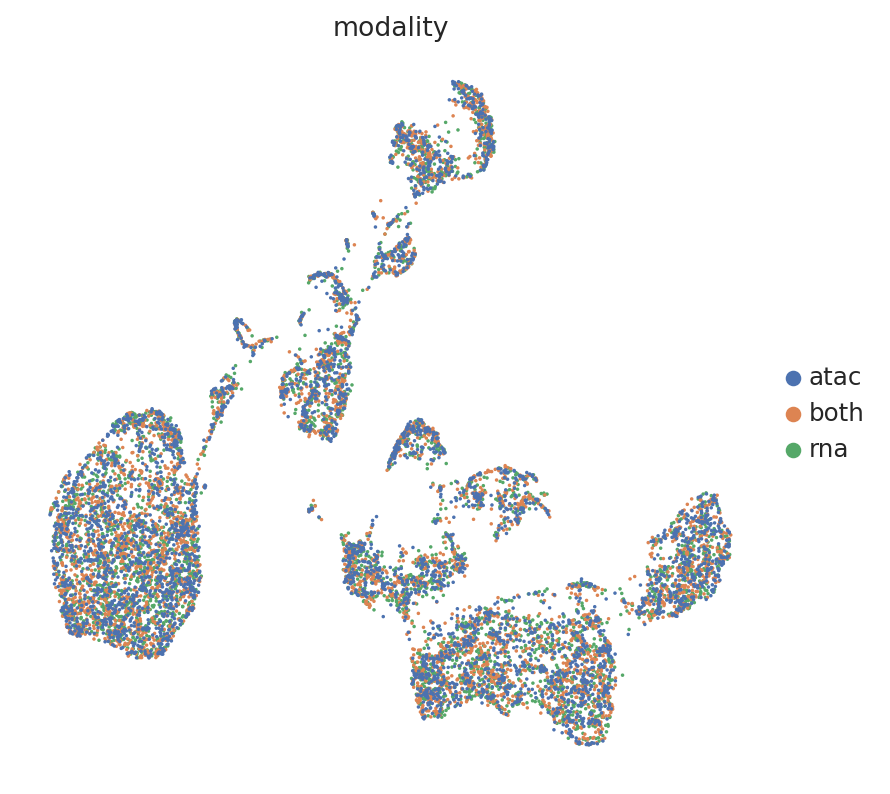

In [40]:
MULTIVI_LATENT_KEY = "X_multivi"

mdata.obsm[MULTIVI_LATENT_KEY] = model.get_latent_representation()
sc.pp.neighbors(mdata, use_rep=MULTIVI_LATENT_KEY)
sc.tl.umap(mdata, min_dist=0.2)

n = mdata.n_obs // 3

# initialize the column first
mdata.obs["modality"] = ""

# set modality of first third to rna
mdata.obs.iloc[:n, mdata.obs.columns.get_loc("modality")] = "rna"

# set modality of second third to both
mdata.obs.iloc[n : 2 * n, mdata.obs.columns.get_loc("modality")] = "both"

# set modality of last third to atac
mdata.obs.iloc[2 * n :, mdata.obs.columns.get_loc("modality")] = "atac"

sc.pl.umap(mdata, color="modality")

## Impute missing modalities

In a well-mixed space, MultiVI can seamlessly impute the missing modalities for single-modality cells.
First, imputing expression and accessibility is done with `get_normalized_expression` and `get_accessibility_estimates`, respectively.

We'll demonstrate this by imputing gene expression for all cells in the dataset (including those that are ATAC-only cells):

In [41]:
imputed_expression = model.get_normalized_expression()

We can demonstrate this on some known marker genes:

First, T-cell marker CD3.

In [43]:
gene_idx = np.where(mdata.var.index == "CD3G")[0]
mdata.obs["CD3G_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(mdata, color="CD3G_imputed")

ValueError: Cannot set a DataFrame without columns to the column CD3G_imputed

Next, NK-Cell marker gene NCAM1 (CD56):

In [ ]:
gene_idx = np.where(mdata.var.index == "NCAM1")[0]
mdata.obs["NCAM1_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(mdata, color="NCAM1_imputed")

Finally, B-Cell Marker CD19:

In [ ]:
gene_idx = np.where(mdata.var.index == "CD19")[0]
mdata.obs["CD19_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(mdata, color="CD19_imputed")

All three marker genes clearly identify their respective populations. Importantly, the imputed gene expression profiles are stable and consistent within that population, **even though many of those cells only measured the ATAC profile of those cells**.